###**Mounting Google Drive**

In [1525]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###**Import Libraries**

In [1526]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold,cross_val_score,KFold,StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [1527]:
from numpy.random import seed
seed(42)
tf.random.set_seed(42)

In [1528]:
from sklearn.metrics import confusion_matrix
def plot_conf_matrix(y_test,y_pred,uniqueclassLabel, title="CMatrix"):
  cm = confusion_matrix(y_true=y_test,y_pred=y_pred,labels=uniqueclassLabel)
  plt.figure(figsize=(5,4))
  plt.title(title)
  #ax = plt.subplot()
  sns.heatmap(cm, annot=True,cmap='Blues',
              yticklabels=uniqueclassLabel,xticklabels=uniqueclassLabel,fmt='3g')

###**Import Utility File**

In [1529]:
import sys
path = "/content/drive/MyDrive/Colab Notebooks/Project_Dissertation"
sys.path.insert(0,path + "/Code")
import morningStarUtilities

### **Import Training Data**

In [1530]:
# uploaded = files.upload()
# train_df = pd.read_csv(io.BytesIO(uploaded['morningstar_removedDuplicates_train_withoutM60.csv']))

In [1531]:
train_df = pd.read_csv(path + "/Data/Final_without_missing_values/morningstar_removedDuplicates_train_withoutLogTransform_withoutM60.csv").set_index("SecId")

### **Import Testing Data**

In [1532]:
# uploaded = files.upload()
# test_df = pd.read_csv(io.BytesIO(uploaded['morningstar_removedDuplicates_test_withoutM60.csv']))

In [1533]:
test_df = pd.read_csv(path + "/Data/Final_without_missing_values/morningstar_removedDuplicates_test_withoutLogTransform_withoutM60.csv").set_index("SecId")

In [1534]:
train_df

,Name,StarRatingM255,SustainabilityRank,Yield_M12,GBRReturnW1,GBRReturnM1,GBRReturnM3,GBRReturnM6,GBRReturnM0,GBRReturnM12,GBRReturnM36,MaxFrontEndLoad,OngoingCostActual,TransactionFeeActual,ManagerTenure,FundTNAV,AverageMarketCapital,MorningstarRiskM255,AlphaM36,BetaM36,R2M36,StandardDeviationM36,SharpeM36,ReturnProfilePreservation,ReturnProfileIncome,ReturnProfileHedging,TrackRecordExtension,Cat_Flex-Cap,Cat_Income,Cat_Large-Cap,Cat_Mid_Small-Cap,Cat_Miscellaneous,Size,Style
SecId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
F000005ETU,Barings Europe Select A EUR Acc,3,4,0.0,0.85,5.10,9.42,21.86,16.19,38.51,9.65,5.00,1.55,0.34,16.67,1.429875e+09,3978.65175,2,0.16,0.88,96.29,17.05,0.57,3,3,3.0,0,0,0,0,1,0,2,3
F0GBR061MQ,Schroder ISF Sust Swiss Eq C Acc CHF,2,2,0.0,1.93,8.73,10.76,18.20,14.37,27.85,6.80,1.00,1.06,0.08,15.83,3.204443e+07,29776.97728,4,-7.08,1.10,85.04,12.23,0.57,2,3,3.0,0,0,0,0,0,1,1,2
F00000ZS1K,Berenberg European Small Cap B,5,2,0.0,0.15,2.60,11.32,25.96,17.16,51.01,19.50,0.00,0.24,0.23,3.67,6.737833e+08,1698.74791,3,10.19,0.99,86.05,21.60,0.92,3,3,3.0,0,0,0,0,1,0,3,3
F000000ITQ,Candriam Eqs L Eurp Optm Qual I EUR Cap,3,4,0.0,0.79,1.74,7.45,11.52,9.99,21.32,7.40,0.00,0.75,0.22,7.17,8.404491e+08,20347.16148,1,-3.22,0.92,93.88,12.45,0.55,2,3,3.0,0,0,0,1,0,0,1,3
F00000SX9M,Janus Henderson INTECH EurpCor A2 EUR,5,3,0.0,0.66,4.99,9.64,20.98,17.27,37.58,8.79,5.00,1.75,1.05,7.42,1.182744e+08,17329.54942,3,1.56,0.95,92.89,15.08,0.54,3,3,3.0,0,0,0,1,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F00000XH8D,ASSII-Europ Focus Eq B Acc GBP,3,3,0.0,0.82,3.94,3.87,7.06,5.43,21.80,4.88,5.00,1.03,0.40,1.92,1.041660e+07,34607.87874,3,-1.06,0.99,91.43,16.16,0.36,2,3,3.0,0,0,0,1,0,0,1,3
F0GBR04BDY,MS INVF European Property A,1,5,0.0,1.71,6.65,15.12,20.83,18.35,29.84,1.29,5.75,1.65,0.26,23.75,3.776127e+07,4036.57364,5,-4.73,1.33,89.06,24.26,0.10,3,1,3.0,0,0,0,0,0,1,2,1
F0GBR04SFG,MSMM European Small Cap A,2,3,0.0,-0.06,0.54,9.39,24.04,18.01,43.01,5.45,5.00,2.13,0.59,2.25,5.323047e+07,2464.49043,4,-3.74,1.05,98.54,20.81,0.31,2,2,2.0,0,0,0,0,1,0,2,2


### **Defining Training, Testing varibales**

In [1535]:
imp_features = ['SustainabilityRank','GBRReturnM1','GBRReturnM3','GBRReturnM0','GBRReturnM36','OngoingCostActual','TransactionFeeActual','FundTNAV',
'AverageMarketCapital','MorningstarRiskM255','AlphaM36','BetaM36','StandardDeviationM36','SharpeM36','Size','Style']
X_train = train_df[imp_features]
y_train = train_df[['StarRatingM255']]

X_test = test_df[imp_features]
y_test = test_df['StarRatingM255']

In [1536]:
y_train = y_train.astype('string')

In [1537]:
from sklearn.preprocessing import OneHotEncoder
y_train_cat = OneHotEncoder().fit_transform(y_train[["StarRatingM255"]]).toarray()
y_train_cat.shape

(886, 5)

In [1538]:
X_train.shape[1], y_train.shape, y_train_cat.shape

(16, (886, 1), (886, 5))

In [1539]:
X_test.shape,y_test.shape

((296, 16), (296,))

### **Scaling the Data**

In [1540]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **Verify the Training and Testing distribution as per Target Variable**

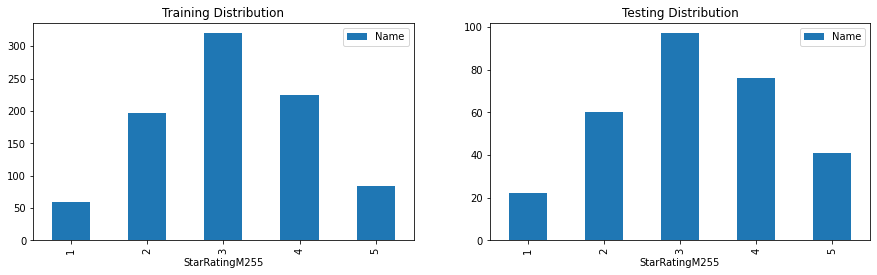

In [1541]:
morningStarUtilities.displayBarSubPlots([train_df,test_df],["Training Distribution", "Testing Distribution"],
                   "StarRatingM255")

### **Creating runtime variables**

In [1542]:
unique_class_label = list(train_df.StarRatingM255.unique())
unique_class_label.sort()
unique_class_label

[1, 2, 3, 4, 5]

### **Defining Neural Network Model**

In [1543]:
# Number of Hidden Layers
round((X_train.shape[1] + len(unique_class_label))/2) + 1

11

### Method 1 - Using Scikit Learn - KerasClassifier


In [1544]:
# def baseline_model():    
#   network = Sequential()
#   network.add(tf.keras.layers.Dense(units=11,activation ='relu', input_dim = X_train.shape[1] ))
#   network.add(tf.keras.layers.Dropout(0.2))
#   network.add(tf.keras.layers.Dense(units=11,activation ='relu'))
#   network.add(tf.keras.layers.Dropout(0.2))
#   network.add(tf.keras.layers.Dense(units=11,activation ='relu'))
#   network.add(tf.keras.layers.Dropout(0.2))
#   network.add(tf.keras.layers.Dense(5,activation='softmax'))
#   network.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#   return network

In [1545]:
# from keras.wrappers.scikit_learn import KerasClassifier
# estimator = KerasClassifier(build_fn = baseline_model, epochs = 500, batch_size = 10, verbose = -1)

In [1546]:
# skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
# results = cross_val_score(estimator, X_train_scaled, y_train, cv = skf)

# print(results)
# print("Result: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [1547]:
# y_pred = estimator.predict(X_test_scaled)

In [1548]:
# plot_conf_matrix(y_test,y_pred,unique_class_label, title="Confusion Matrix for " + clf.__class__.__name__)
# print("Accuracy Score for " +  estimator.__class__.__name__ + "  " 
#         + str(accuracy_score(y_test,y_pred)) )
# print("F1 Score for " + estimator.__class__.__name__ + "  " + 
#         str(f1_score(y_test, y_pred, average='weighted')))

### Method 2 - Using Sequential Model

In [1549]:
model = Sequential()
model.add(tf.keras.layers.Dense(units=11,activation ='relu', input_shape = (16,) ))
#model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=11,activation ='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=6,activation ='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=5,activation='softmax'))
model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [1550]:
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_132 (Dense)            (None, 11)                187       
_________________________________________________________________
dense_133 (Dense)            (None, 11)                132       
_________________________________________________________________
dropout_66 (Dropout)         (None, 11)                0         
_________________________________________________________________
dense_134 (Dense)            (None, 6)                 72        
_________________________________________________________________
dropout_67 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_135 (Dense)            (None, 5)                 35        
Total params: 426
Trainable params: 426
Non-trainable params: 0
_______________________________________________________

In [1551]:
# Handling Imbalanced Classes using class_weight

class_wt = {0: 2.05,
                1: 1.25,
                2: 1.1,
                3: 1.2,
                4: 1.75}

In [1552]:
history = model.fit(X_train_scaled,y_train_cat,validation_split=0.2,
                    epochs=225, verbose=1,batch_size=20,class_weight=class_wt)

Epoch 1/225
36/36 [==============================] - 1s 8ms/step - loss: 2.1480 - accuracy: 0.2260 - val_loss: 1.6125 - val_accuracy: 0.3202
Epoch 2/225
36/36 [==============================] - 0s 3ms/step - loss: 2.0686 - accuracy: 0.2924 - val_loss: 1.5888 - val_accuracy: 0.3034
Epoch 3/225
36/36 [==============================] - 0s 4ms/step - loss: 2.0387 - accuracy: 0.3305 - val_loss: 1.5733 - val_accuracy: 0.3427
Epoch 4/225
36/36 [==============================] - 0s 3ms/step - loss: 2.0276 - accuracy: 0.3418 - val_loss: 1.5622 - val_accuracy: 0.3652
Epoch 5/225
36/36 [==============================] - 0s 3ms/step - loss: 2.0082 - accuracy: 0.3531 - val_loss: 1.5514 - val_accuracy: 0.3483
Epoch 6/225
36/36 [==============================] - 0s 3ms/step - loss: 2.0031 - accuracy: 0.3517 - val_loss: 1.5412 - val_accuracy: 0.3820
Epoch 7/225
36/36 [==============================] - 0s 3ms/step - loss: 1.9920 - accuracy: 0.3658 - val_loss: 1.5331 - val_accuracy: 0.3708
Epoch 8/225
3

### Plot Loss and Accuracy

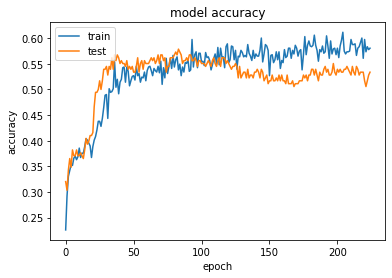

In [1553]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

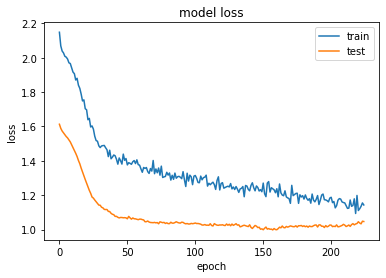

In [1554]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [1555]:
y_pred = model.predict(X_test_scaled)

In [1556]:
y_pred

array([[3.1204706e-01, 4.9198124e-01, 1.9595532e-01, 1.6443764e-05,
        5.4380966e-16],
       [1.2339126e-30, 9.4774279e-15, 1.3075745e-03, 1.9229561e-01,
        8.0639690e-01],
       [2.3206763e-02, 4.0509167e-01, 5.5360186e-01, 1.8096751e-02,
        2.9941075e-06],
       ...,
       [6.1657410e-03, 2.7488121e-01, 6.1746031e-01, 9.9830709e-02,
        1.6620271e-03],
       [1.8099275e-01, 5.0397044e-01, 3.1379825e-01, 1.2385776e-03,
        1.0670899e-09],
       [2.0486747e-20, 9.8258413e-10, 2.1226991e-02, 4.3358600e-01,
        5.4518700e-01]], dtype=float32)

In [1557]:
y_pred = np.argmax(y_pred, axis=1)

In [1558]:
y_pred = y_pred + 1 # Ratings are from 1 to 5

In [1559]:
y_pred

array([2, 5, 3, 3, 3, 3, 3, 4, 3, 5, 4, 3, 3, 4, 3, 2, 1, 4, 2, 4, 4, 3,
       2, 2, 5, 3, 3, 2, 4, 4, 1, 2, 4, 3, 3, 2, 2, 5, 2, 3, 4, 2, 5, 3,
       4, 4, 2, 4, 1, 2, 4, 2, 3, 2, 3, 3, 1, 4, 2, 4, 3, 4, 5, 4, 2, 3,
       4, 4, 3, 3, 2, 2, 3, 4, 3, 3, 4, 2, 4, 4, 4, 4, 4, 3, 2, 3, 3, 3,
       3, 4, 1, 4, 4, 3, 3, 2, 4, 3, 1, 1, 3, 3, 5, 2, 3, 4, 4, 3, 3, 1,
       3, 2, 4, 5, 4, 4, 5, 3, 2, 3, 2, 2, 3, 2, 4, 4, 4, 4, 4, 2, 5, 3,
       3, 2, 2, 4, 3, 4, 1, 3, 4, 2, 4, 1, 2, 3, 2, 2, 4, 4, 4, 4, 4, 1,
       2, 2, 3, 3, 3, 3, 4, 3, 2, 2, 5, 4, 1, 3, 3, 3, 2, 3, 2, 3, 4, 4,
       2, 4, 3, 2, 2, 4, 3, 2, 4, 5, 3, 3, 5, 3, 5, 1, 2, 3, 3, 2, 3, 5,
       4, 3, 3, 3, 4, 5, 2, 2, 4, 4, 4, 3, 4, 3, 4, 3, 3, 3, 3, 3, 4, 3,
       4, 3, 3, 4, 2, 3, 2, 2, 3, 5, 4, 2, 3, 3, 4, 2, 4, 1, 4, 5, 4, 3,
       2, 4, 3, 4, 4, 1, 1, 3, 4, 2, 4, 4, 4, 3, 2, 2, 3, 2, 2, 3, 3, 3,
       1, 5, 3, 5, 1, 3, 2, 2, 3, 4, 4, 3, 1, 4, 2, 3, 4, 4, 4, 5, 1, 2,
       3, 3, 2, 2, 3, 1, 3, 3, 2, 5])

In [1560]:
y_test.values

array([3, 5, 2, 3, 3, 3, 4, 4, 3, 5, 4, 3, 4, 4, 3, 2, 2, 5, 3, 4, 5, 3,
       2, 2, 5, 3, 4, 2, 4, 4, 2, 2, 4, 3, 2, 2, 3, 5, 2, 4, 5, 1, 5, 3,
       4, 5, 3, 3, 1, 2, 3, 1, 4, 3, 4, 2, 1, 5, 2, 5, 4, 4, 5, 4, 2, 4,
       4, 4, 3, 2, 3, 2, 4, 3, 2, 3, 5, 2, 5, 4, 2, 4, 4, 3, 3, 3, 2, 4,
       3, 4, 2, 3, 3, 3, 3, 2, 4, 2, 1, 2, 4, 4, 5, 3, 3, 4, 4, 3, 3, 3,
       3, 1, 4, 5, 5, 5, 4, 3, 2, 3, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 2,
       3, 2, 1, 3, 3, 3, 1, 4, 4, 3, 3, 1, 3, 3, 3, 2, 4, 4, 4, 3, 3, 1,
       2, 1, 3, 3, 4, 5, 4, 2, 3, 2, 5, 4, 1, 3, 4, 4, 2, 4, 2, 2, 5, 3,
       2, 5, 3, 3, 3, 4, 3, 2, 4, 5, 3, 3, 5, 3, 5, 2, 3, 3, 4, 2, 3, 4,
       4, 3, 4, 3, 5, 5, 2, 2, 4, 3, 3, 2, 3, 3, 4, 2, 5, 3, 1, 3, 5, 2,
       3, 4, 3, 3, 1, 2, 4, 2, 4, 5, 3, 2, 3, 5, 4, 1, 4, 1, 5, 5, 5, 3,
       3, 4, 2, 4, 4, 1, 2, 2, 5, 2, 4, 3, 4, 4, 2, 3, 3, 1, 3, 3, 4, 3,
       2, 5, 3, 5, 1, 4, 2, 2, 3, 4, 5, 3, 1, 4, 2, 2, 3, 3, 4, 5, 1, 2,
       3, 2, 3, 4, 4, 1, 3, 3, 3, 5])

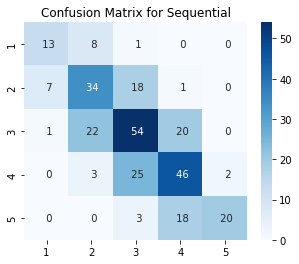

In [1561]:
plot_conf_matrix(y_test.values,y_pred,unique_class_label, title="Confusion Matrix for " + model.__class__.__name__)

In [1562]:
print("Accuracy Score for " +  model.__class__.__name__ + "  " 
        + str(accuracy_score(y_test.values,y_pred)) )
print("F1 Score for " + model.__class__.__name__ + "  " + 
        str(f1_score(y_test.values, y_pred, average='weighted')))

Accuracy Score for Sequential  0.5641891891891891
F1 Score for Sequential  0.5668841831174737


In [1563]:
model_json = model.to_json()
with open('model.json','w') as json_file:
  json_file.write(model_json)

In [1564]:
from keras.models import save_model
model_weights = save_model(model, '/content/model_weights.hdf5')

#### Performing testing using Loaded model

In [1565]:
with open('model.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Sequential", "config": {"name": "sequential_33", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 16], "dtype": "float32", "sparse": false, "ragged": false, "name": "dense_132_input"}}, {"class_name": "Dense", "config": {"name": "dense_132", "trainable": true, "batch_input_shape": [null, 16], "dtype": "float32", "units": 11, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dense", "config": {"name": "dense_133", "trainable": true, "dtype": "float32", "units": 11, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer"

In [1566]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('model_weights.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [1567]:
y_pred_loaded = network_loaded.predict(X_test_scaled)

In [1568]:
y_pred_loaded = np.argmax(y_pred_loaded, axis=1)

In [1569]:
y_pred_loaded +=1

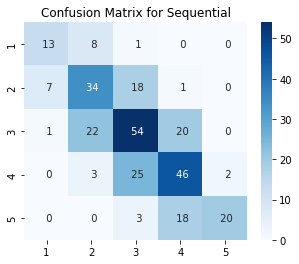

In [1570]:
plot_conf_matrix(y_test.values,y_pred_loaded,unique_class_label, title="Confusion Matrix for " + model.__class__.__name__)

#### Prediction on Asia Developed Dataset

In [1571]:
asia_df = pd.read_csv("/content/sample_data/Asia_Developed.csv").set_index("SecId")
asia_df = morningStarUtilities.createSize_InvestmentTypeFeature(asia_df)


In [1572]:
asia_df[asia_df.FundTNAV.isnull()]

,Name,StarRatingM255,SustainabilityRank,CategoryName,Yield_M12,GBRReturnW1,GBRReturnM1,GBRReturnM3,GBRReturnM6,GBRReturnM0,GBRReturnM12,GBRReturnM36,GBRReturnM60,MaxFrontEndLoad,OngoingCostActual,TransactionFeeActual,ManagerTenure,FundTNAV,EquityStyleBox,AverageMarketCapital,MorningstarRiskM255,AlphaM36,BetaM36,R2M36,StandardDeviationM36,SharpeM36,ReturnProfilePreservation,ReturnProfileIncome,ReturnProfileHedging,TrackRecordExtension,Size,Style
SecId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
F00001071Q,BIEF Emerging Markets A GBP Acc,4,2,Global Emerging Markets Equity,0.62047,1.43,1.64,-3.35,-7.72,0.09,10.79,10.05,NaN,NaN,1.12,1.17,24.08,NaN,2,28614.24791,4,2.47,1.02,89.7,16.24,0.66,3,1,3.0,False,1,2


In [1573]:
asia_df.drop(index='F00001071Q',inplace=True)


In [1574]:
X_asia = asia_df[imp_features]
y_asia = asia_df['StarRatingM255']
X_asia_scaled = scaler.transform(X_asia)

In [1575]:
y_asia_pred = network_loaded.predict(X_asia_scaled)
y_asia_pred = np.argmax(y_asia_pred, axis=1)
y_asia_pred += 1

In [1576]:
y_asia.shape

(432,)

In [1577]:
y_asia_pred.shape

(432,)

In [1578]:
print("Accuracy Score for " +  model.__class__.__name__ + "  " 
        + str(accuracy_score(y_asia.values,y_asia_pred)) )
print("F1 Score for " + model.__class__.__name__ + "  " + 
        str(f1_score(y_asia.values, y_asia_pred, average='weighted')))

Accuracy Score for Sequential  0.4837962962962963
F1 Score for Sequential  0.4775401771574459


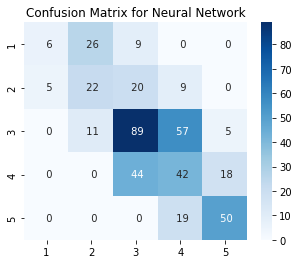

In [1579]:
plot_conf_matrix(y_asia.values,y_asia_pred,unique_class_label, title="Confusion Matrix for Neural Network" )